# LSTM weather prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 12)

In [5]:
import warnings
warnings.simplefilter('ignore')

$$
\text { Relative RMSE }=\frac{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-{V}_{i}\right)^{2}}}{\sqrt{\frac{1}{n} \sum_{i=1}^{n}\left({Y}_{i}-\bar{Y}\right)^{2}}}
$$

In [6]:
def relative_rmse(target, preds):
    rmse = mean_squared_error(target, preds, squared=False)
    avg = np.full(len(preds), preds.mean())
    const_rmse = mean_squared_error(target, avg, squared=False)
    return rmse / const_rmse

### Reading data

In [7]:
weather_df = pd.read_csv('NASA_weather_latitude_51.5_longitude_37.0.csv', skiprows=8)
weather_df["DATE"] = pd.to_datetime(weather_df["DAY"], format='%Y%m%d')

In [8]:
weather_df.head()

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
0,19840101,2500.0,-5.20,0.26,0.479845,7.59,2.93,NaN,1984-01-01
1,19840102,3250.0,0.30,1.26,0.610800,7.50,2.77,NaN,1984-01-02
2,19840103,4240.0,-1.74,0.99,0.534874,7.11,0.72,NaN,1984-01-03
3,19840104,2740.0,-1.13,0.66,0.592380,5.12,0.44,NaN,1984-01-04
4,19840105,1890.0,-3.70,0.99,0.569003,3.09,0.88,NaN,1984-01-05


### Train - test split

In [9]:
train_tmp = weather_df[weather_df.DATE.dt.year > 1999].copy()
train_data = train_tmp[train_tmp.DATE.dt.year < 2015].copy()

In [10]:
test_tmp = weather_df[weather_df.DATE.dt.year > 2014].copy()
test_data = test_tmp[test_tmp.DATE.dt.year < 2020].copy()

In [11]:
display(train_data.head())
display(test_data.tail())

,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
5844,20000101,3550.0,-12.80,-7.20,0.276993,1.56,1.21,NaN,2000-01-01
5845,20000102,4140.0,-12.74,-6.73,0.297244,3.87,2.47,NaN,2000-01-02
5846,20000103,4590.0,-16.81,-11.44,0.185930,1.34,0.40,NaN,2000-01-03
5847,20000104,4600.0,-15.39,-8.39,0.220140,2.95,0.12,NaN,2000-01-04
5848,20000105,3610.0,-11.50,-5.81,0.310407,3.70,0.65,NaN,2000-01-05


,DAY,IRRAD,TMIN,TMAX,VAP,WIND,RAIN,SNOWDEPTH,DATE
13144,20191227,1280.0,-1.88,0.75,0.547656,1.42,1.23,NaN,2019-12-27
13145,20191228,990.0,-3.79,-1.13,0.423742,3.27,1.59,NaN,2019-12-28
13146,20191229,1070.0,-6.74,-3.27,0.356630,2.94,1.63,NaN,2019-12-29
13147,20191230,750.0,-6.81,-3.80,0.363870,3.76,0.47,NaN,2019-12-30
13148,20191231,1200.0,-3.92,-0.81,0.474842,6.01,2.31,NaN,2019-12-31


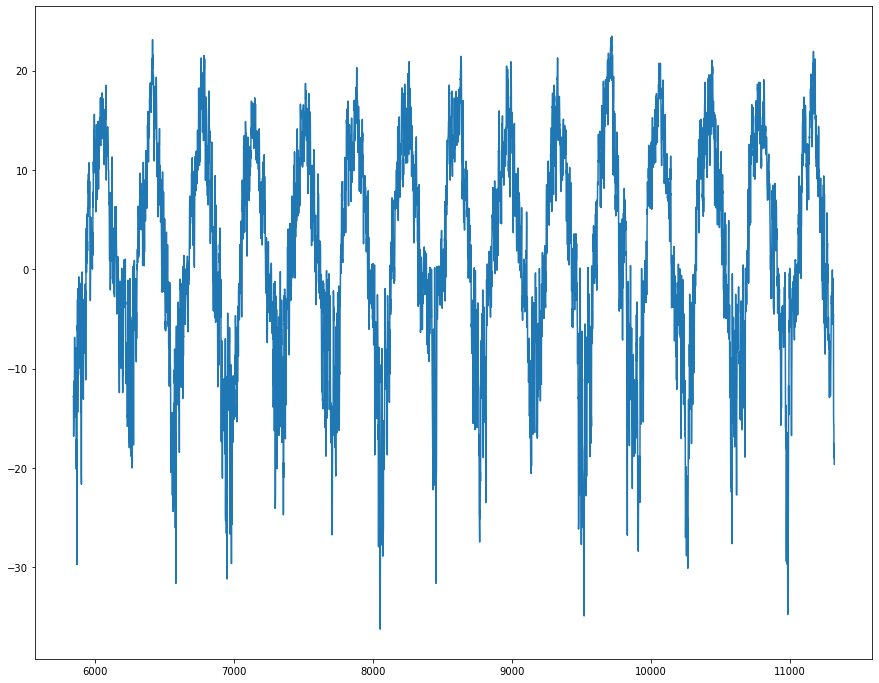

In [12]:
train_data.TMIN.plot();

### LSTM

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=1000, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [14]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [15]:
train_window = 365

In [16]:
train_tmin = train_data.TMIN.values.astype(float)
test_tmin = test_data.TMIN.values.astype(float)

In [17]:
train_tmin.shape, test_tmin.shape

((5479,), (1826,))

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_tmin_normalized = scaler.fit_transform(train_tmin .reshape(-1, 1))
train_tmin_normalized = torch.FloatTensor(train_tmin_normalized).view(-1)

In [19]:
train_inout_seq = create_inout_sequences(train_tmin_normalized, train_window)

In [20]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
epochs = 1

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    print(f'epoch: {i+1}\tloss: {single_loss.item():10.8f}')

KeyboardInterrupt: 

In [22]:
fut_pred = test_tmin.shape[0]

test_inputs = train_tmin_normalized[-train_window:].tolist()

In [23]:
len(test_inputs)

365

In [24]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [25]:
len(test_inputs)

2191

In [26]:
preds_normalized = test_inputs[train_window:]

In [27]:
preds = scaler.inverse_transform(np.array(preds_normalized).reshape(-1, 1))

In [28]:
preds.shape

(1826, 1)

In [29]:
preds = torch.FloatTensor(preds).view(-1).tolist()

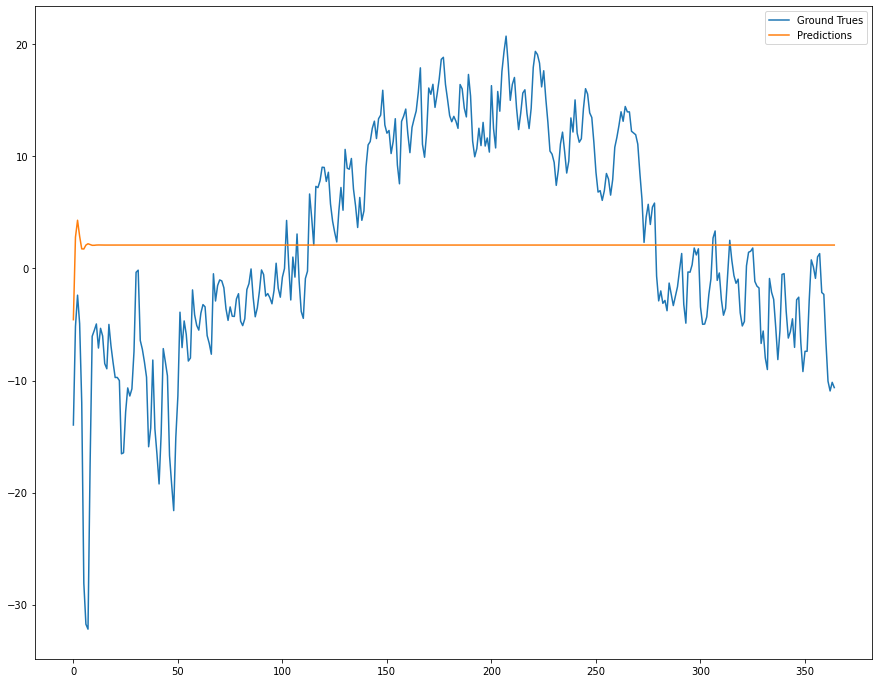

In [30]:
plt.plot(test_tmin[:365]);
plt.plot(preds[:365]);
plt.legend(['Ground Trues', 'Predictions'])